In [1]:
# !wget https://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('glove.6B.50d.txt', binary=False, no_header=True)

In [2]:
!pip install torch torch-geometric

import pandas as pd
import os
from collections import defaultdict, Counter
import torch
import torch.nn as nn

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score, r2_score, mean_squared_error
import matplotlib.pyplot as plt
torch.manual_seed(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.7 MB/s eta 0:00:00


In [3]:
!unzip drive/MyDrive/slt_challenge/transcripts_outputFiles.zip


Archive:  drive/MyDrive/slt_challenge/transcripts_outputFiles.zip
   creating: transcripts_outputFiles/
   creating: transcripts_outputFiles/SFT_outputFiles/
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-103.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-034.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-131.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-039.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-059.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-073.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-030.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-080.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-069.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-test-002.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-083.txt  
  inflating: tra

In [102]:
def load_graph_info(nodes_degree_txt, nodes_edges_txt):
  nodes_features = defaultdict(dict)
  edges = []
  with open(nodes_degree_txt, 'r') as nodes_degree_file, open(nodes_edges_txt, 'r') as nodes_edges_file:
      reading_nodes, reading_edges = False, False

      for line in nodes_edges_file:
          line = line.strip()
          if (not line) or line.startswith("id*int") or line.startswith("source*int"):
              continue

          if line.startswith("*Nodes"):
              # start reading node info
              reading_nodes = True
              reading_edges = False
          elif line.startswith("*DirectedEdges"):
              # start reading edge info
              reading_nodes = False
              reading_edges = True

          elif reading_nodes:
            # parse node info
              parts = line.split(" ", 2)
              node_id = int(parts[0])
              label = parts[1].strip('"')
              nodes_features[node_id]['label'] = label


          elif reading_edges:
            # parse edge info
              parts = line.split()
              source = int(parts[0])
              target = int(parts[1])
              edges.append((source, target))

      for line in nodes_degree_file:
        line = line.strip()
        if (not line) or (not line.startswith("Node Degree")):
          parts = line.split()
          node_id = int(parts[0])
          degree = parts[1].strip('"')
          nodes_features[node_id]['degree'] = degree

      # print(len(nodes_features), len(edges))
      return nodes_features, edges


def get_word_embedding(word, embedding_dim=50):
    try:
        return torch.tensor(word_vectors[word], dtype=torch.float)
    except KeyError:
        # for words not in the vocabulary, use a zero vector
        # print('WARNING: word not in the vocabulary: ', word)
        return torch.zeros(embedding_dim)


def prep_data_for_gnn(nodes_features, edges):
    # mapping from node ID to index
    node_id_to_index = {node_id: i for i, node_id in enumerate(nodes_features.keys())}

    # create node features: node degrees and word embeddings)
    features = []
    for node_id in nodes_features.keys():
        node_label = nodes_features[node_id]['label']
        node_embeddings = get_word_embedding(node_label)
        # print(node_id,nodes_features[node_id]['degree'])
        # new_value = torch.tensor([15], dtype=torch.int64)
        # tensor = torch.cat((node_embeddings, new_value))

        features.append(node_embeddings)
    x = torch.stack(features)  # Node feature matrix

    # create edge index tensor
    edge_index = torch.tensor(
        [[node_id_to_index[src], node_id_to_index[dst]] for src, dst in edges],
        dtype=torch.long,
    ).t().contiguous()
    return x, edge_index


def get_datalist(id_list, label_list, transcript_folder):
  """
  returns a list of Data objects
  """
  data_list = []
  id_label_list = [(id, label) for id, label in zip(id_list, label_list)]
  for id, label in id_label_list:
    filepath = os.path.join(transcript_folder, id)
    nodes_features, edges = load_graph_info(f'{filepath}_dir_nodes_degree.txt', f'{filepath}_dir_nodes_edges.txt')
    x, edge_index = prep_data_for_gnn(nodes_features, edges)
    graph_data = Data(x=x, edge_index=edge_index, y=label)
    data_list.append(graph_data)
  return data_list


def get_dataloader(data_list, batch_size=None):
  if not batch_size:
    batch_size = len(data_list)
    print('Setting batch size to ', batch_size)
  return DataLoader(data_list, batch_size=batch_size, shuffle=False)


class GNNClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x


def train_gnn(train_datalist, train_batch_size=None, hidden_dim=64, lr=0.01, epoches=250):
  torch.manual_seed(42)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  train_dataloader = get_dataloader(train_datalist, batch_size=train_batch_size)
  num_node_features = next(iter(train_dataloader)).x.size(1)
  num_classes = pd.Series([data.y for data in train_datalist]).nunique()
  model = GNNClassifier(input_dim=num_node_features, hidden_dim=hidden_dim, output_dim=num_classes).to(device)
  optimizer = Adam(model.parameters(), lr=lr)

  # Train
  for epoch in range(epoches):  # train for 50 epochs
      model.train()
      total_loss = 0

      for batch in train_dataloader:
          batch = batch.to(device)
          optimizer.zero_grad()
          out = model(batch)
          loss = cross_entropy(out, batch.y)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.5f}')

  return model


def eval_gnn(model, eval_datalist, print_results=True, batch_size=None):
    model.eval()
    logits_list, pred_list, y_list = [], [], []
    eval_dataloader = get_dataloader(eval_datalist, batch_size=batch_size)
    for batch in eval_dataloader:
        logits = model(batch)
        pred = logits.argmax(dim=1)
        logits_list.append(logits)
        pred_list.append(pred)
        y_list.append(batch.y)
    # concatenate data from all batches
    logits_all = torch.cat(logits_list, dim=0)
    pred_all = torch.cat(pred_list, dim=0)
    y_all = torch.cat(y_list, dim=0)
    # get metrics
    results, disp = calc_metrics(y_all, pred_all)
    return logits_all, pred_all, results, disp


def calc_metrics(actual_labels, pred_vals, print_results=True):
  results = {}
  results['accuracy'] = accuracy_score(actual_labels, pred_vals)
  results['f1'] = f1_score(actual_labels, pred_vals, average='macro')
  results['precision'] = precision_score(actual_labels, pred_vals, average='macro')
  results['recall'] = recall_score(actual_labels, pred_vals, average='macro')

  cm = confusion_matrix(actual_labels, pred_vals)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['HC', 'MCI', 'DEM'])
  # print and plot results
  if print_results:
    for metric, value in results.items():
      print(f'{metric}: {value:.3f}')
    disp.plot()
    plt.show()
  return results, disp


class NNMetaModel(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
      super().__init__()
      self.fc1 = Linear(input_dim, hidden_dim)
      self.fc2 = Linear(hidden_dim, output_dim)

  def forward(self, x):
      x = self.fc1(x)
      x = x.relu()
      x = self.fc2(x)
      return x

def train_nn_metamodel(features, labels, epochs=50, hidden_dim=32, lr=0.01, n_tasks=3):
    num_classes = len(torch.unique(labels))
    input_dim = n_tasks * num_classes  # input dimensions equals to number of tasks (CTD, SFT, PFT) * number of classes
    model = NNMetaModel(input_dim, hidden_dim=hidden_dim, output_dim=num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(features)
        loss = cross_entropy(output, labels)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')
    return model


Fold 0:

    train set for base model: 100 samples; label count: Counter({0: 52, 1: 38, 2: 10}), 
    train set for meta model: 25 samples; label count: Counter({0: 13, 1: 10, 2: 2}), 
    dev set for meta model: 32 samples; label count: Counter({0: 17, 1: 11, 2: 4})
CTD
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11565
Epoch 50, Loss: 0.38587
Epoch 100, Loss: 0.01598
Epoch 150, Loss: 0.00295
Epoch 200, Loss: 0.00148
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.480
f1: 0.318
precision: 0.319
recall: 0.331


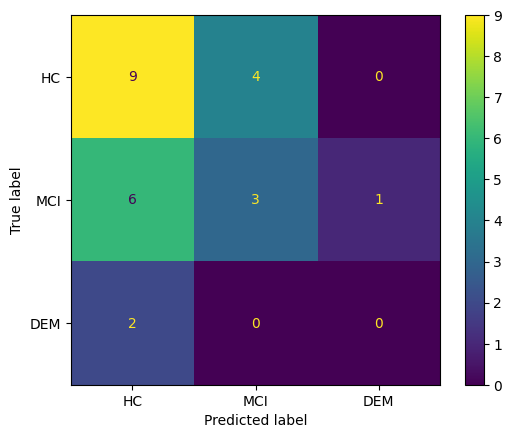

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.344
f1: 0.240
precision: 0.234
recall: 0.248


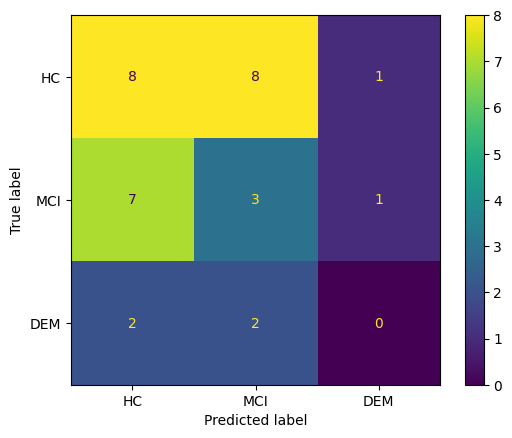

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.11585
Epoch 50, Loss: 0.55007
Epoch 100, Loss: 0.05246
Epoch 150, Loss: 0.00512
Epoch 200, Loss: 0.00225
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.406
f1: 0.293
precision: 0.284
recall: 0.319


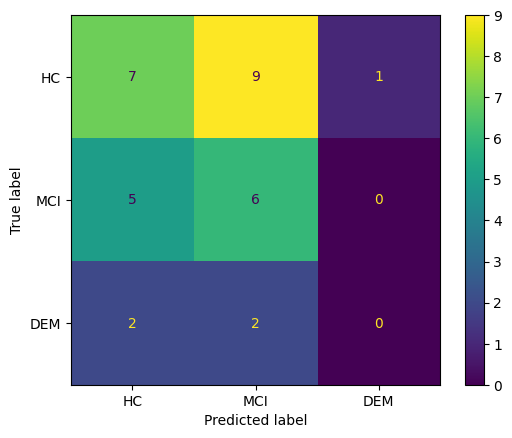

SFT
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11008
Epoch 50, Loss: 0.21773
Epoch 100, Loss: 0.00386
Epoch 150, Loss: 0.00149
Epoch 200, Loss: 0.00086
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.640
f1: 0.437
precision: 0.420
recall: 0.456


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


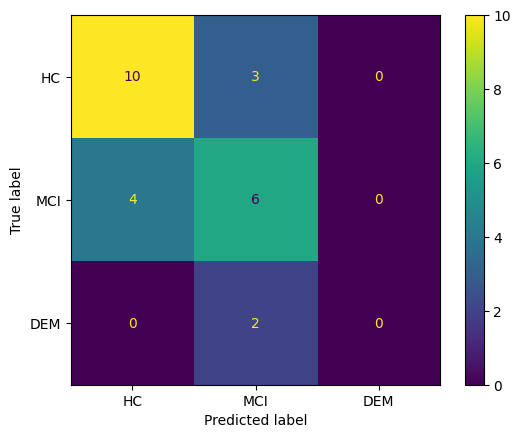

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.500
f1: 0.362
precision: 0.363
recall: 0.367


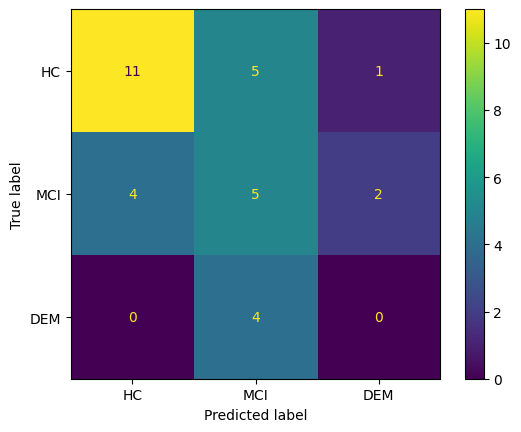

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.11367
Epoch 50, Loss: 0.32773
Epoch 100, Loss: 0.00661
Epoch 150, Loss: 0.00189
Epoch 200, Loss: 0.00104
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.469
f1: 0.339
precision: 0.342
recall: 0.348


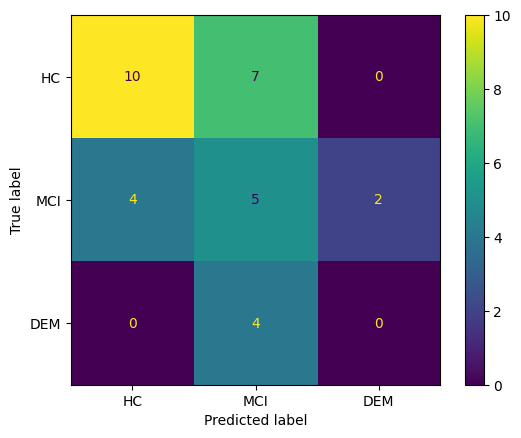

PFT
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08342
Epoch 50, Loss: 0.00298
Epoch 100, Loss: 0.00027
Epoch 150, Loss: 0.00018
Epoch 200, Loss: 0.00013
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.480
f1: 0.313
precision: 0.319
recall: 0.323


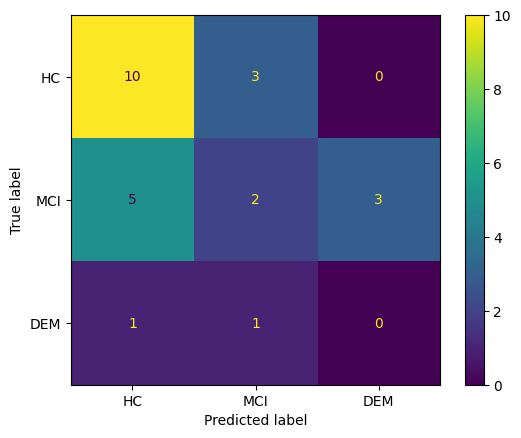

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.594
f1: 0.520
precision: 0.562
recall: 0.511


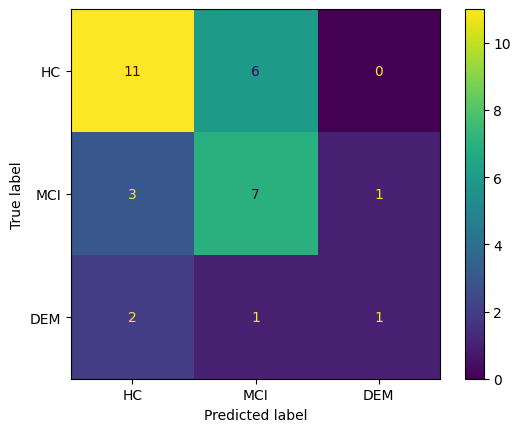

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.08508
Epoch 50, Loss: 0.01181
Epoch 100, Loss: 0.00063
Epoch 150, Loss: 0.00036
Epoch 200, Loss: 0.00024
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.562
f1: 0.463
precision: 0.476
recall: 0.459


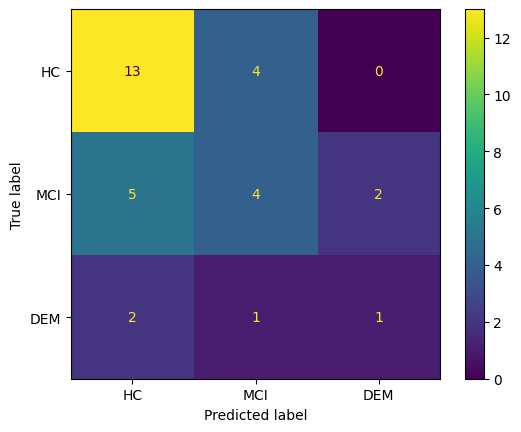

Fold 1:

    train set for base model: 100 samples; label count: Counter({0: 51, 1: 39, 2: 10}), 
    train set for meta model: 25 samples; label count: Counter({0: 13, 1: 10, 2: 2}), 
    dev set for meta model: 32 samples; label count: Counter({0: 18, 1: 10, 2: 4})
CTD
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11447
Epoch 50, Loss: 0.49431
Epoch 100, Loss: 0.03114
Epoch 150, Loss: 0.00371
Epoch 200, Loss: 0.00180
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.440
f1: 0.283
precision: 0.288
recall: 0.297


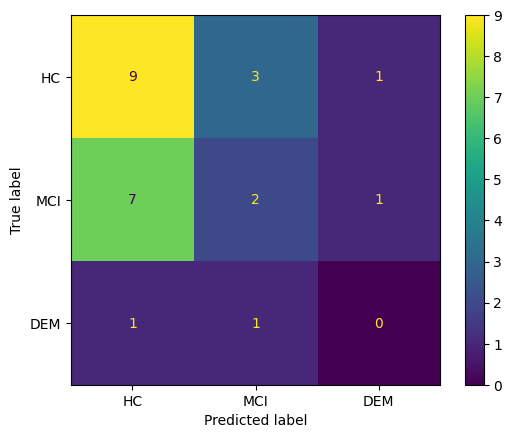

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.375
f1: 0.245
precision: 0.242
recall: 0.252


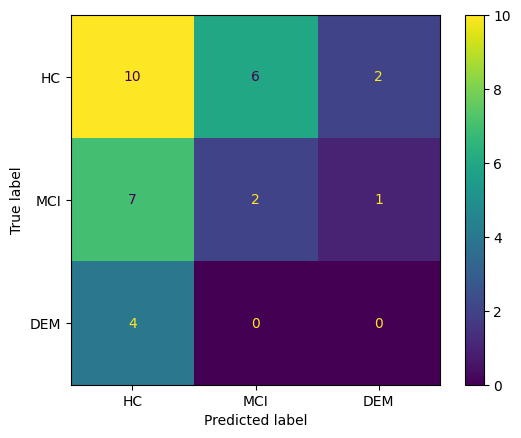

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.11448
Epoch 50, Loss: 0.53623
Epoch 100, Loss: 0.06770
Epoch 150, Loss: 0.00563
Epoch 200, Loss: 0.00244
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.500
f1: 0.420
precision: 0.426
recall: 0.420


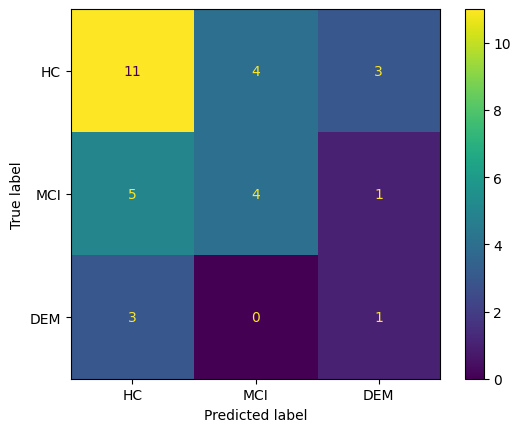

SFT
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11377
Epoch 50, Loss: 0.32641
Epoch 100, Loss: 0.00466
Epoch 150, Loss: 0.00143
Epoch 200, Loss: 0.00081
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.600
f1: 0.376
precision: 0.400
recall: 0.408


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


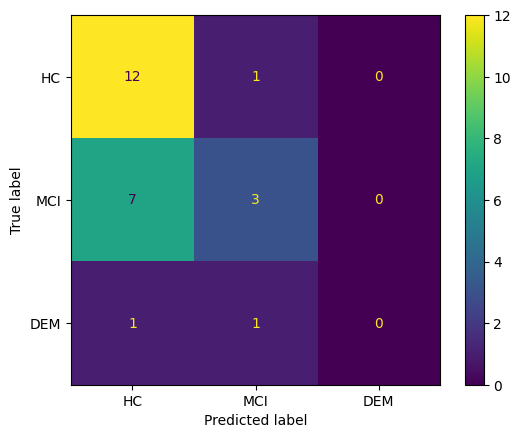

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.531
f1: 0.314
precision: 0.291
recall: 0.344


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


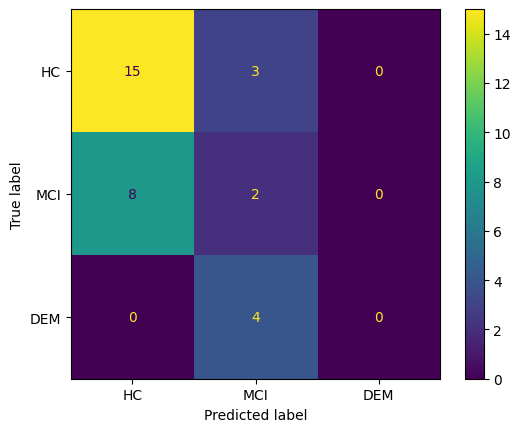

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.11202
Epoch 50, Loss: 0.35236
Epoch 100, Loss: 0.00747
Epoch 150, Loss: 0.00196
Epoch 200, Loss: 0.00109
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.594
f1: 0.383
precision: 0.361
recall: 0.411


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


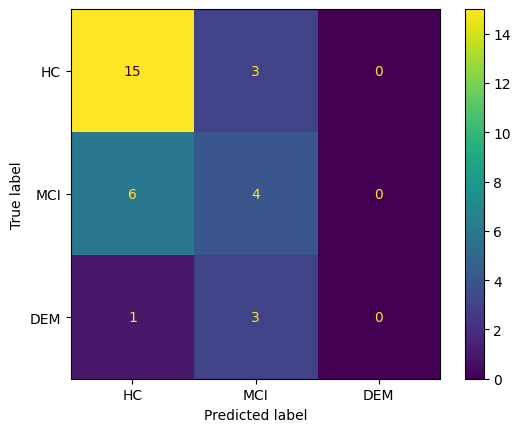

PFT
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08481
Epoch 50, Loss: 0.00264
Epoch 100, Loss: 0.00029
Epoch 150, Loss: 0.00019
Epoch 200, Loss: 0.00013
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.560
f1: 0.398
precision: 0.390
recall: 0.405


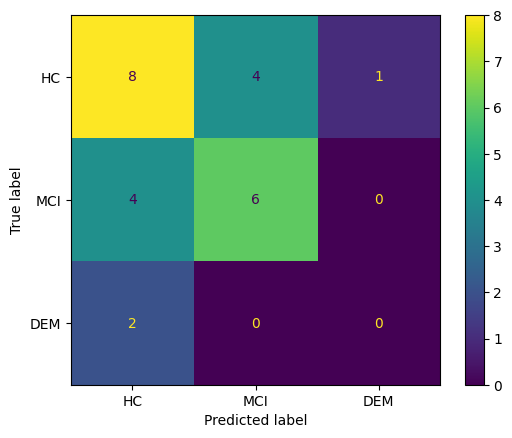

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.438
f1: 0.323
precision: 0.333
recall: 0.319


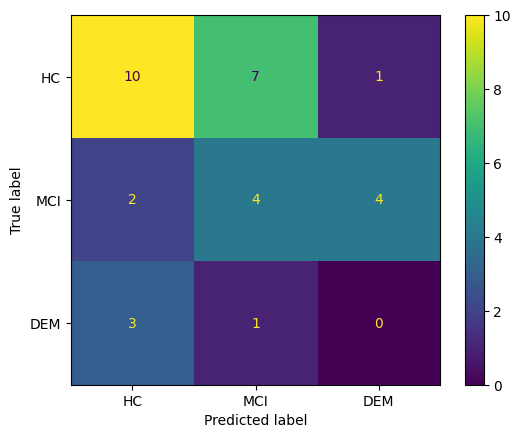

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.08311
Epoch 50, Loss: 0.00556
Epoch 100, Loss: 0.00048
Epoch 150, Loss: 0.00030
Epoch 200, Loss: 0.00021
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.500
f1: 0.369
precision: 0.383
recall: 0.356


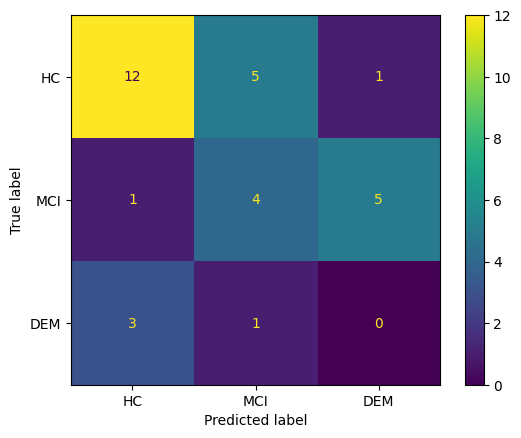

Fold 2:

    train set for base model: 100 samples; label count: Counter({0: 52, 1: 37, 2: 11}), 
    train set for meta model: 26 samples; label count: Counter({0: 14, 1: 9, 2: 3}), 
    dev set for meta model: 31 samples; label count: Counter({0: 16, 1: 13, 2: 2})
CTD
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11394
Epoch 50, Loss: 0.53934
Epoch 100, Loss: 0.06603
Epoch 150, Loss: 0.00647
Epoch 200, Loss: 0.00250
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.500
f1: 0.368
precision: 0.366
recall: 0.389


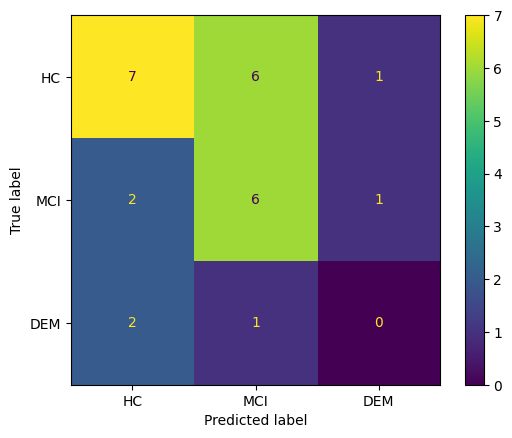

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.484
f1: 0.338
precision: 0.349
recall: 0.332


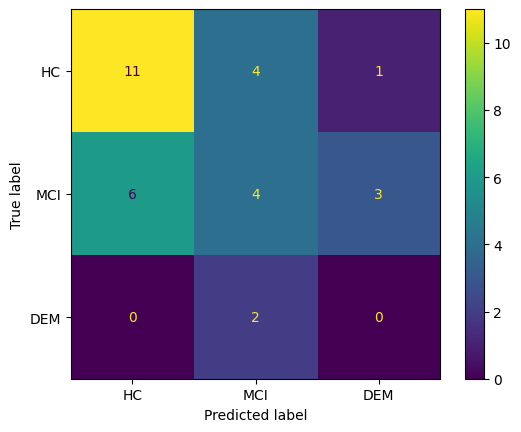

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11444
Epoch 50, Loss: 0.54945
Epoch 100, Loss: 0.07401
Epoch 150, Loss: 0.00662
Epoch 200, Loss: 0.00273
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.516
f1: 0.362
precision: 0.363
recall: 0.362


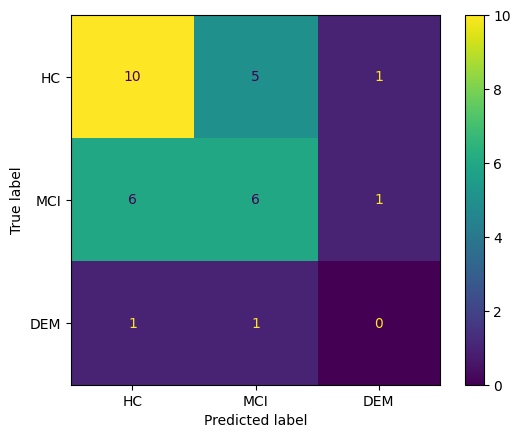

SFT
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11025
Epoch 50, Loss: 0.22792
Epoch 100, Loss: 0.00361
Epoch 150, Loss: 0.00125
Epoch 200, Loss: 0.00073
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.269
f1: 0.197
precision: 0.214
recall: 0.193


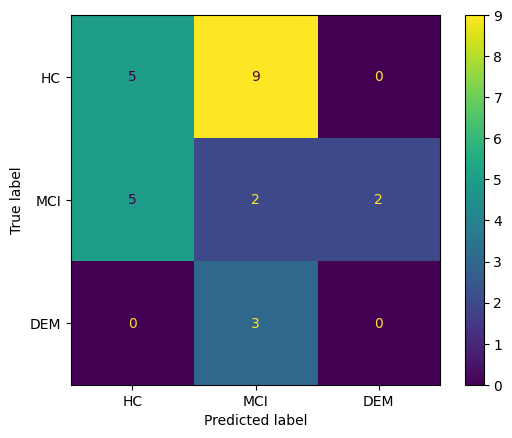

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.419
f1: 0.293
precision: 0.292
recall: 0.300


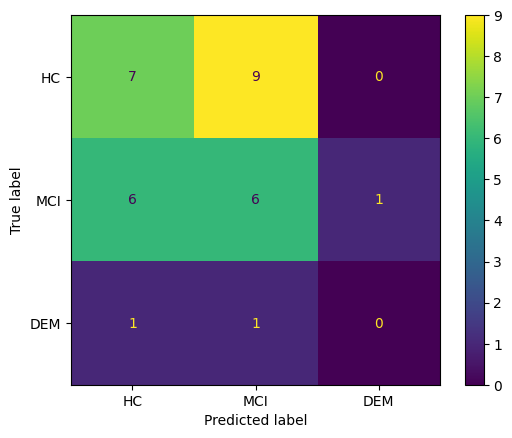

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11161
Epoch 50, Loss: 0.31460
Epoch 100, Loss: 0.00560
Epoch 150, Loss: 0.00158
Epoch 200, Loss: 0.00088
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.484
f1: 0.459
precision: 0.443
recall: 0.487


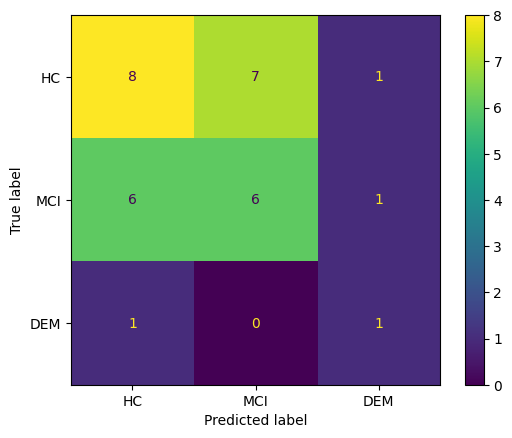

PFT
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08591
Epoch 50, Loss: 0.00551
Epoch 100, Loss: 0.00051
Epoch 150, Loss: 0.00031
Epoch 200, Loss: 0.00021
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.346
f1: 0.222
precision: 0.222
recall: 0.228


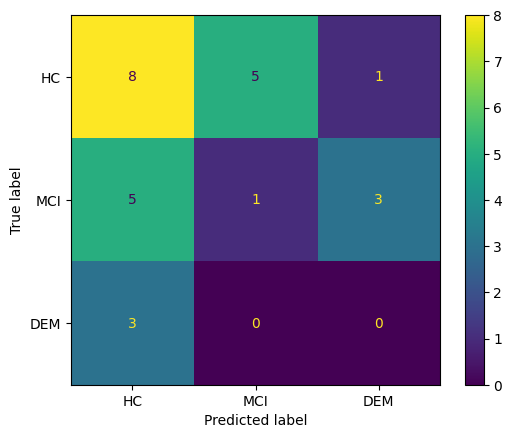

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.516
f1: 0.362
precision: 0.363
recall: 0.362


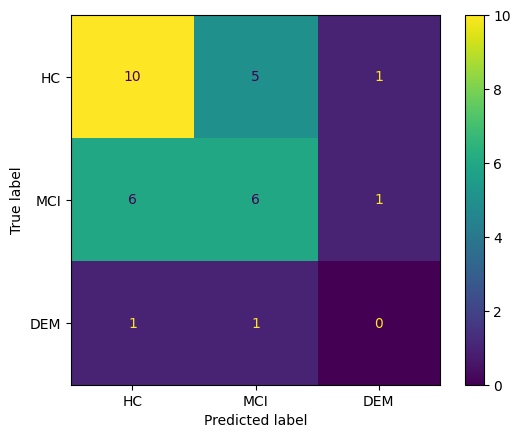

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.08671
Epoch 50, Loss: 0.02133
Epoch 100, Loss: 0.00080
Epoch 150, Loss: 0.00044
Epoch 200, Loss: 0.00029
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.419
f1: 0.287
precision: 0.291
recall: 0.290


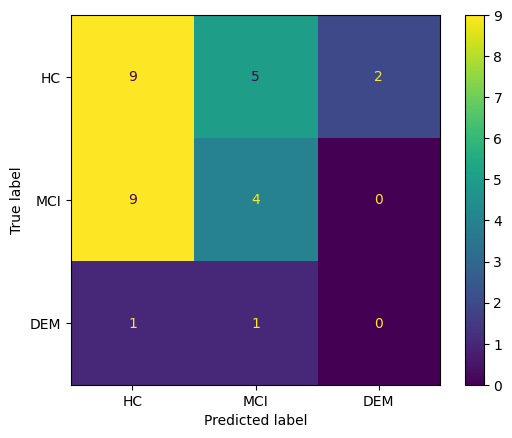

Fold 3:

    train set for base model: 100 samples; label count: Counter({0: 52, 1: 37, 2: 11}), 
    train set for meta model: 26 samples; label count: Counter({0: 14, 1: 9, 2: 3}), 
    dev set for meta model: 31 samples; label count: Counter({0: 16, 1: 13, 2: 2})
CTD
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11393
Epoch 50, Loss: 0.53384
Epoch 100, Loss: 0.06605
Epoch 150, Loss: 0.00679
Epoch 200, Loss: 0.00280
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.269
f1: 0.204
precision: 0.218
recall: 0.193


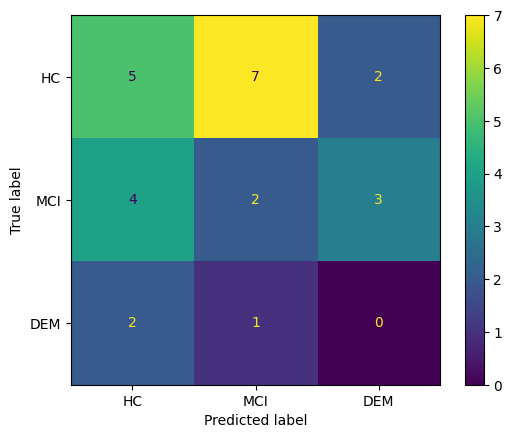

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.516
f1: 0.348
precision: 0.344
recall: 0.357


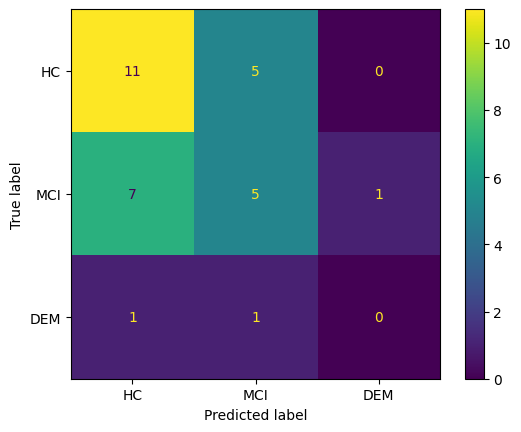

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11445
Epoch 50, Loss: 0.60971
Epoch 100, Loss: 0.11369
Epoch 150, Loss: 0.00977
Epoch 200, Loss: 0.00355
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.548
f1: 0.367
precision: 0.367
recall: 0.378


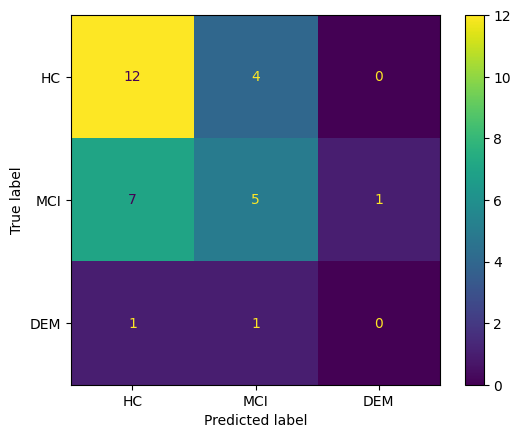

SFT
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11012
Epoch 50, Loss: 0.22763
Epoch 100, Loss: 0.00365
Epoch 150, Loss: 0.00143
Epoch 200, Loss: 0.00085
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.346
f1: 0.226
precision: 0.225
recall: 0.228


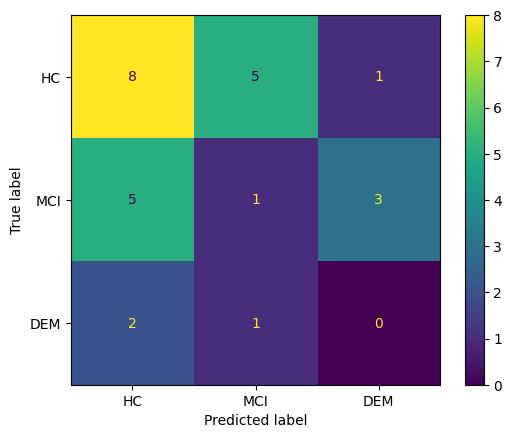

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.581
f1: 0.406
precision: 0.405
recall: 0.413


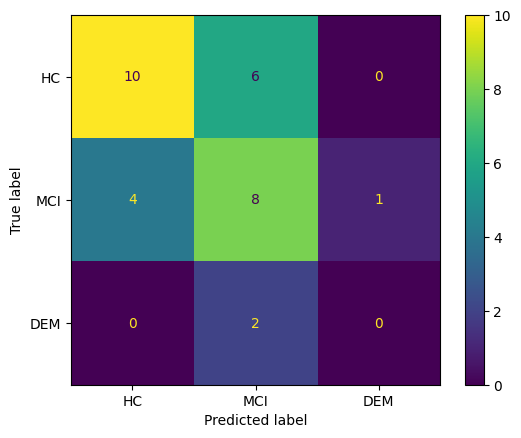

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11406
Epoch 50, Loss: 0.33240
Epoch 100, Loss: 0.00564
Epoch 150, Loss: 0.00182
Epoch 200, Loss: 0.00103
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.581
f1: 0.399
precision: 0.386
recall: 0.413


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


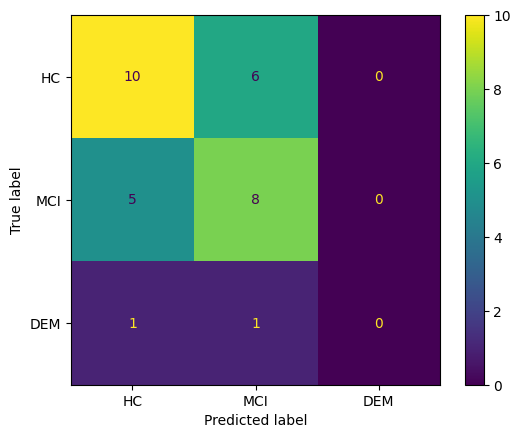

PFT
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08586
Epoch 50, Loss: 0.00166
Epoch 100, Loss: 0.00023
Epoch 150, Loss: 0.00016
Epoch 200, Loss: 0.00012
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.346
f1: 0.214
precision: 0.204
recall: 0.228


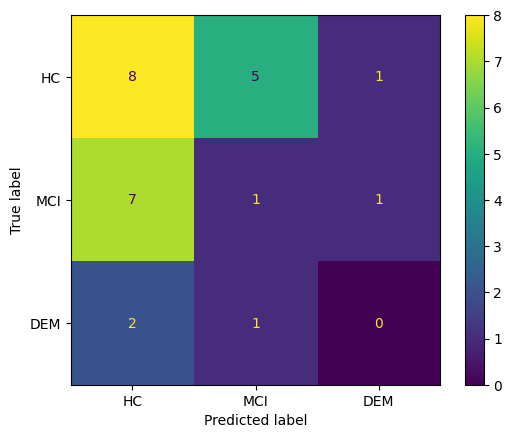

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.452
f1: 0.315
precision: 0.311
recall: 0.321


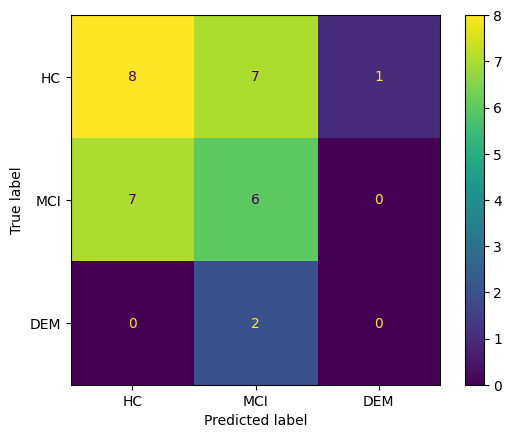

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.08675
Epoch 50, Loss: 0.01383
Epoch 100, Loss: 0.00072
Epoch 150, Loss: 0.00041
Epoch 200, Loss: 0.00027
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.484
f1: 0.337
precision: 0.352
recall: 0.332


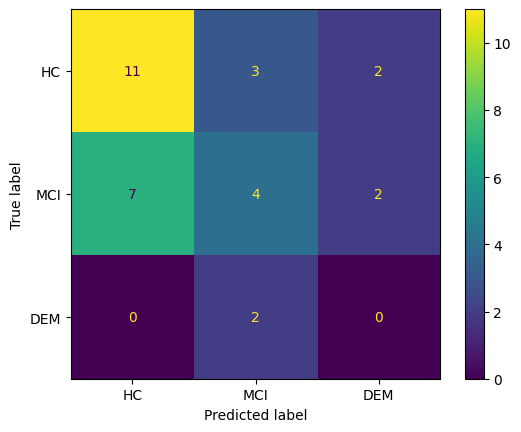

Fold 4:

    train set for base model: 100 samples; label count: Counter({0: 53, 1: 37, 2: 10}), 
    train set for meta model: 26 samples; label count: Counter({0: 14, 1: 10, 2: 2}), 
    dev set for meta model: 31 samples; label count: Counter({0: 15, 1: 12, 2: 4})
CTD
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11568
Epoch 50, Loss: 0.46029
Epoch 100, Loss: 0.04430
Epoch 150, Loss: 0.00462
Epoch 200, Loss: 0.00170
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.500
f1: 0.340
precision: 0.333
recall: 0.348


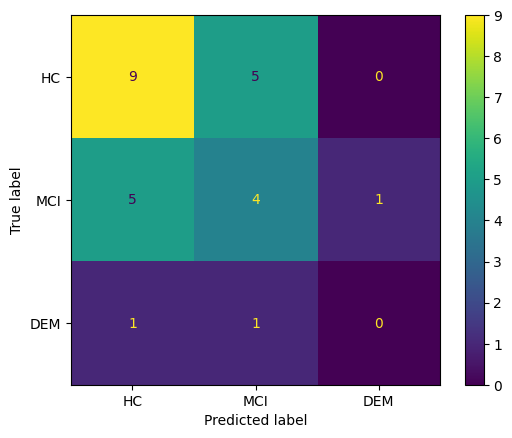

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.484
f1: 0.325
precision: 0.308
recall: 0.356


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


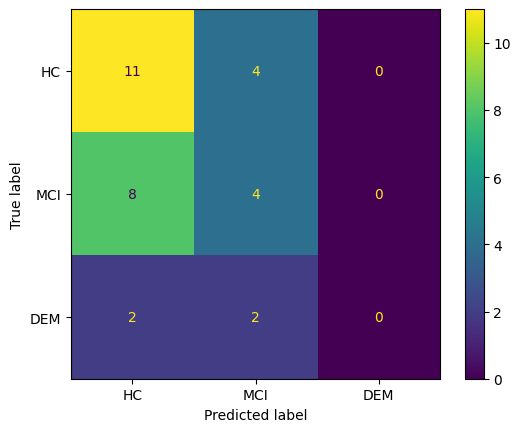

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11510
Epoch 50, Loss: 0.54032
Epoch 100, Loss: 0.08696
Epoch 150, Loss: 0.00821
Epoch 200, Loss: 0.00300
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.452
f1: 0.326
precision: 0.315
recall: 0.339


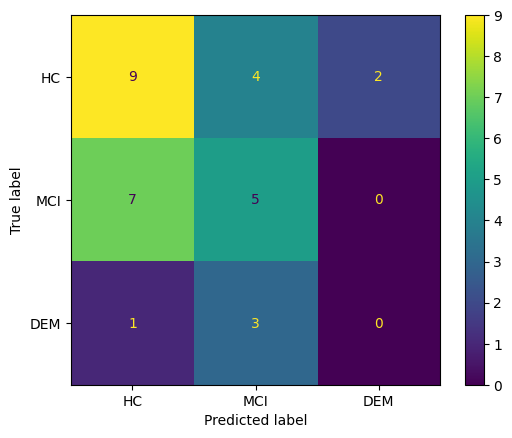

SFT
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11274
Epoch 50, Loss: 0.21109
Epoch 100, Loss: 0.00235
Epoch 150, Loss: 0.00097
Epoch 200, Loss: 0.00060
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.346
f1: 0.243
precision: 0.243
recall: 0.243


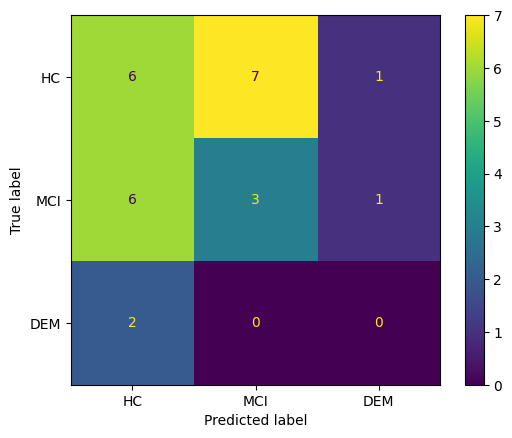

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.387
f1: 0.274
precision: 0.257
recall: 0.294


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


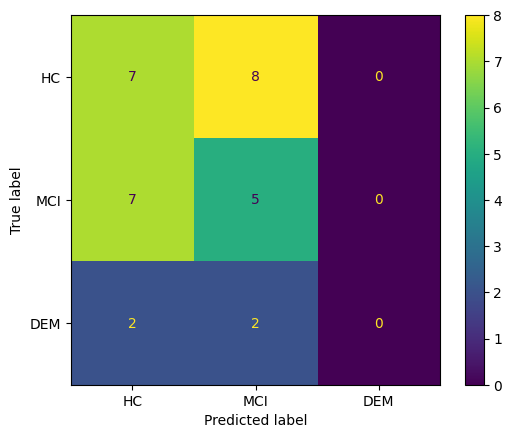

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11199
Epoch 50, Loss: 0.30834
Epoch 100, Loss: 0.00598
Epoch 150, Loss: 0.00171
Epoch 200, Loss: 0.00094
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.484
f1: 0.335
precision: 0.318
recall: 0.361


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


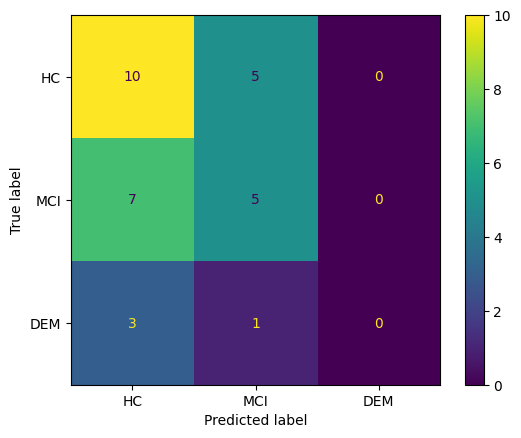

PFT
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08292
Epoch 50, Loss: 0.00369
Epoch 100, Loss: 0.00031
Epoch 150, Loss: 0.00020
Epoch 200, Loss: 0.00014
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.577
f1: 0.512
precision: 0.510
recall: 0.538


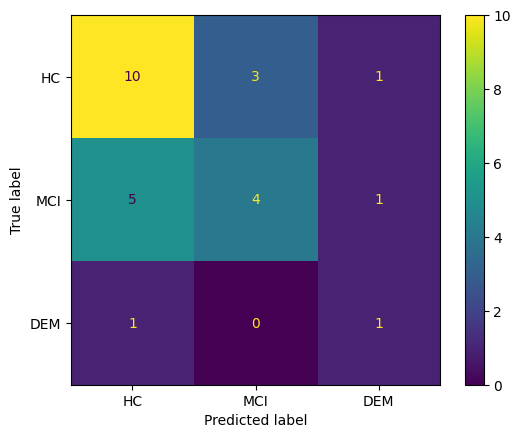

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.323
f1: 0.220
precision: 0.214
recall: 0.233


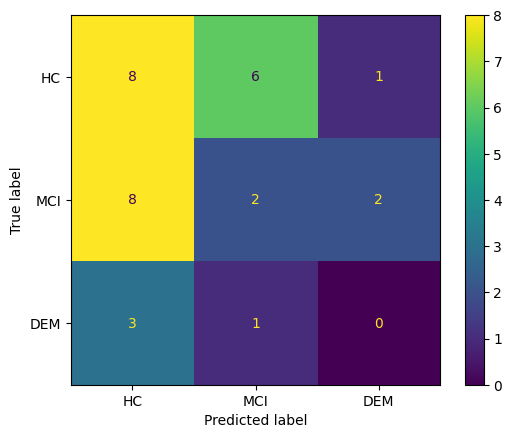

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.08506
Epoch 50, Loss: 0.01188
Epoch 100, Loss: 0.00055
Epoch 150, Loss: 0.00032
Epoch 200, Loss: 0.00022
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.387
f1: 0.340
precision: 0.343
recall: 0.344


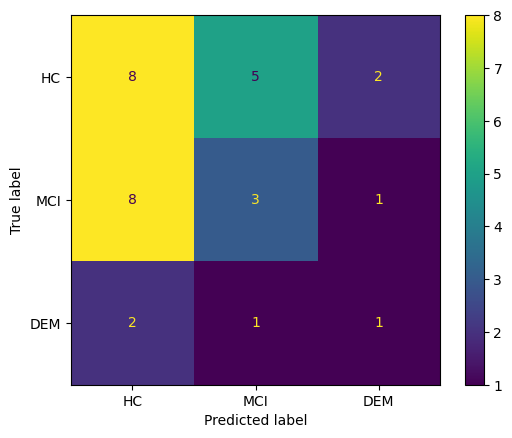

In [106]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TASKS = ['CTD', 'SFT', 'PFT']
LABEL_MAPPING = {'HC': 0,
                 'MCI': 1,
                 'Dementia': 2}

metadata = pd.read_csv("PROCESS_METADATA_ALL.csv")
# shuffle df
metadata = metadata.sample(frac=1, random_state=42, ignore_index=False)
metadata['diagnosis_coded'] = metadata['diagnosis'].map(LABEL_MAPPING)

df_traindev = metadata[metadata['Tr/Tt/Dv'].isin(['train', 'dev'])]
id_traindev, label_traindev = df_traindev['anyon_IDs'], df_traindev['diagnosis_coded']
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf_dict = defaultdict(dict)
for fold_index, (train_index, dev_index) in enumerate(skf.split(id_traindev, label_traindev)):
    print(f"Fold {fold_index}:")
    base_train_id, ensemble_train_id, base_train_label, ensemble_train_label = train_test_split(id_traindev[train_index], label_traindev[train_index],
                                                    stratify=label_traindev[train_index],
                                                    test_size=0.2)
    print(f'''
    train set for base model: {len(base_train_label)} samples; label count: {Counter(base_train_label)},
    train set for meta model: {len(ensemble_train_label)} samples; label count: {Counter(ensemble_train_label)},
    dev set for meta model: {len(label_traindev[dev_index])} samples; label count: {Counter(label_traindev[dev_index])}''')

    logits_for_ensemble_training = []
    pred_for_ensemble_training = []

    logits_for_ensemble_validation = []
    pred_for_ensemble_validation = []

    for task in TASKS:
        print(f'----------- Task: {task} -----------')
        transcript_folder = f"transcripts_outputFiles/{task}_outputFiles"
        base_train_datalist = get_datalist(base_train_id, base_train_label, transcript_folder)
        ensemble_train_datalist = get_datalist(ensemble_train_id, ensemble_train_label, transcript_folder)
        ensemble_dev_datalist = get_datalist(id_traindev[dev_index], label_traindev[dev_index], transcript_folder)
        # training gnn in order to get the logits
        print('Training base model...')
        trained_gnn = train_gnn(base_train_datalist)
        # get logits and pred for metamodel training
        print('Validating on meta model train set...')
        task_logits_ensemble_training, task_pred_ensemble_training, _, _ = eval_gnn(trained_gnn, ensemble_train_datalist, print_results=False)
        logits_for_ensemble_training.append(task_logits_ensemble_training)
        pred_for_ensemble_training.append(task_pred_ensemble_training)
        # get logits and pred for metamodel validation
        print('Validating on meta model dev set...')
        task_logits_ensemble_validation, task_pred_ensemble_validation, _, _ = eval_gnn(trained_gnn, ensemble_dev_datalist, print_results=False)
        logits_for_ensemble_validation.append(task_logits_ensemble_validation)
        pred_for_ensemble_validation.append(task_pred_ensemble_validation)
        # for comparison: gnn only, no metamodel
        print('Training on base model train set + meta model train set...')
        trained_gnn_individual_task = train_gnn(base_train_datalist + ensemble_train_datalist)
        print('Validating on meta model dev set...')
        _, _, kf_dict[fold_index][f'{task}_gnn_results'], kf_dict[fold_index][f'{task}_gnn_cm_disp'] = eval_gnn(trained_gnn_individual_task, ensemble_dev_datalist)
    kf_dict[fold_index]['logits_for_ensemble_training'] = logits_for_ensemble_training
    kf_dict[fold_index]['logits_for_ensemble_validation'] = logits_for_ensemble_validation
    kf_dict[fold_index]['pred_for_ensemble_training'] = pred_for_ensemble_training
    kf_dict[fold_index]['pred_for_ensemble_validation'] = pred_for_ensemble_validation
    kf_dict[fold_index]['ensemble_train_label'] = ensemble_train_label
    kf_dict[fold_index]['ensemble_dev_label'] = label_traindev[dev_index]


Training lr...
accuracy: 0.656
f1: 0.475
precision: 0.458
recall: 0.519


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


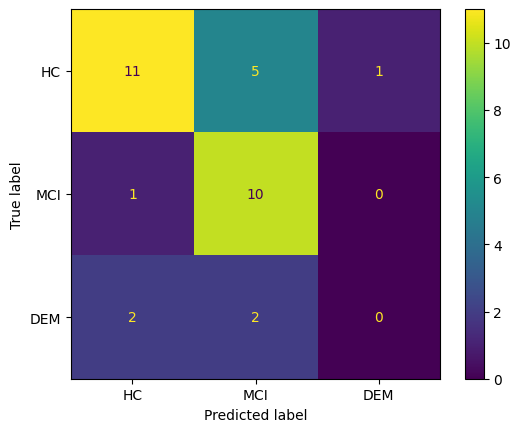

Training svm...
accuracy: 0.656
f1: 0.447
precision: 0.427
recall: 0.476


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


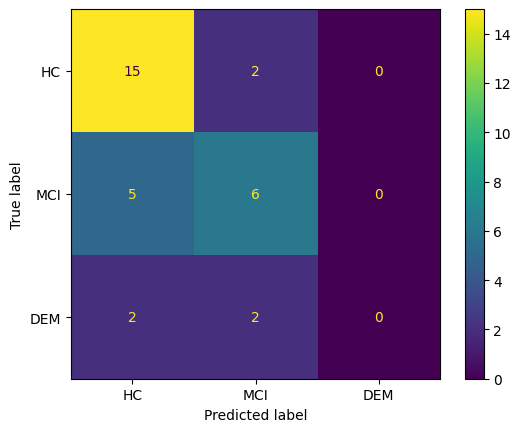

Training rf...
accuracy: 0.594
f1: 0.420
precision: 0.401
recall: 0.458


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


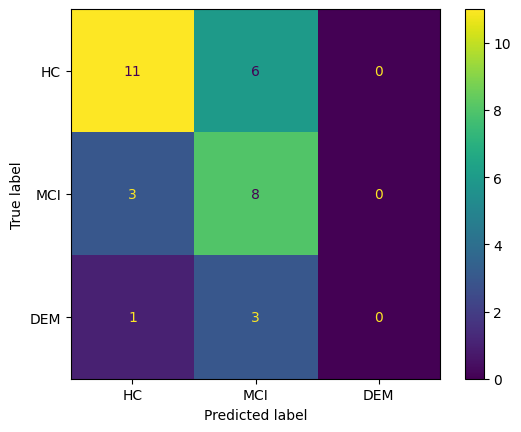

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training knn...
accuracy: 0.469
f1: 0.314
precision: 0.294
recall: 0.337


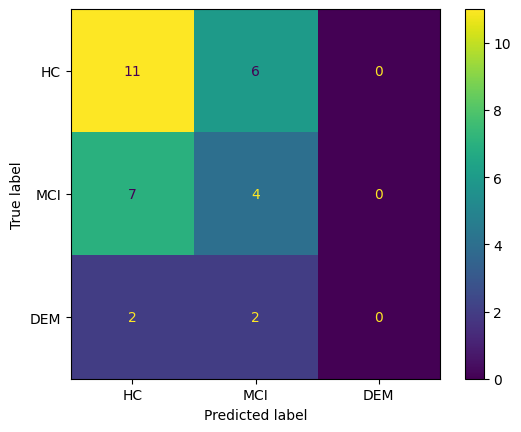

Epoch 10, Loss: 0.5499
Epoch 20, Loss: 0.2748
Epoch 30, Loss: 0.1416
Epoch 40, Loss: 0.0707
Epoch 50, Loss: 0.0405
accuracy: 0.594
f1: 0.437
precision: 0.429
recall: 0.447


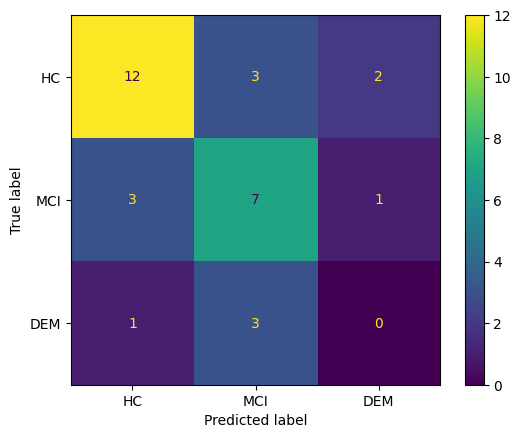

Training lr...
accuracy: 0.375
f1: 0.225
precision: 0.216
recall: 0.237


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


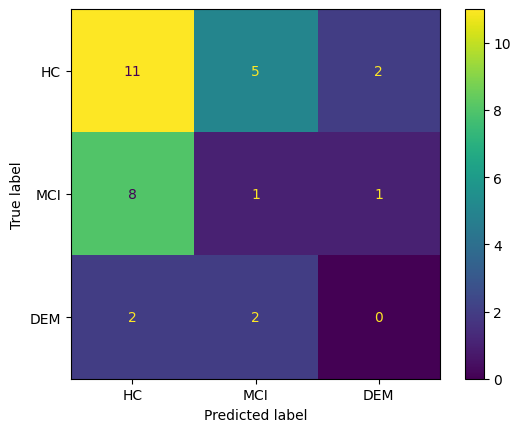

Training svm...
accuracy: 0.469
f1: 0.286
precision: 0.267
recall: 0.307


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


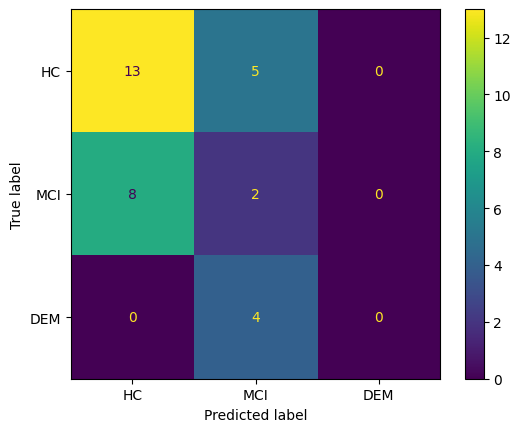

Training rf...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy: 0.438
f1: 0.285
precision: 0.270
recall: 0.304


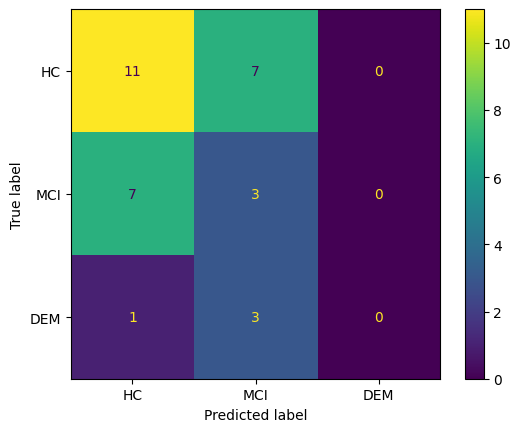

Training knn...
accuracy: 0.594
f1: 0.341
precision: 0.343
recall: 0.381


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


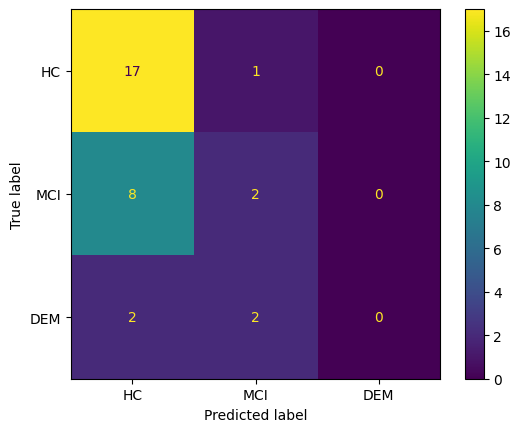

Epoch 10, Loss: 0.6510
Epoch 20, Loss: 0.3571
Epoch 30, Loss: 0.2033
Epoch 40, Loss: 0.1126
Epoch 50, Loss: 0.0632
accuracy: 0.469
f1: 0.424
precision: 0.614
recall: 0.387


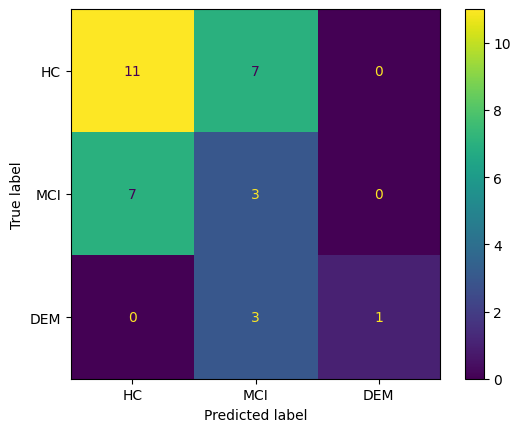

Training lr...
accuracy: 0.419
f1: 0.288
precision: 0.288
recall: 0.290


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


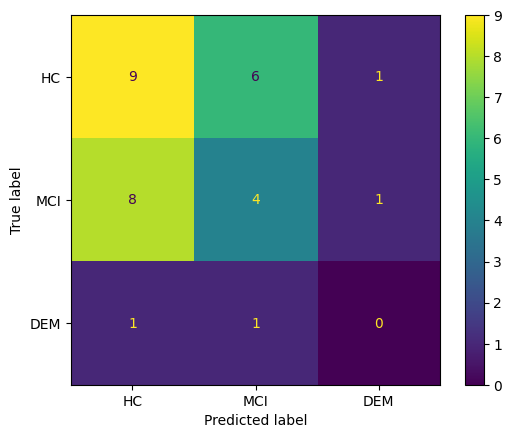

Training svm...
accuracy: 0.516
f1: 0.267
precision: 0.339
recall: 0.338


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


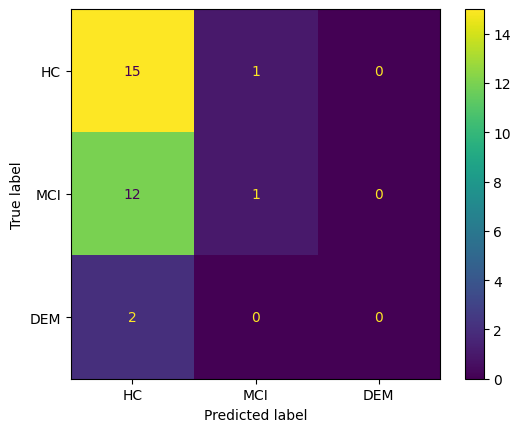

Training rf...
accuracy: 0.548
f1: 0.376
precision: 0.370
recall: 0.383


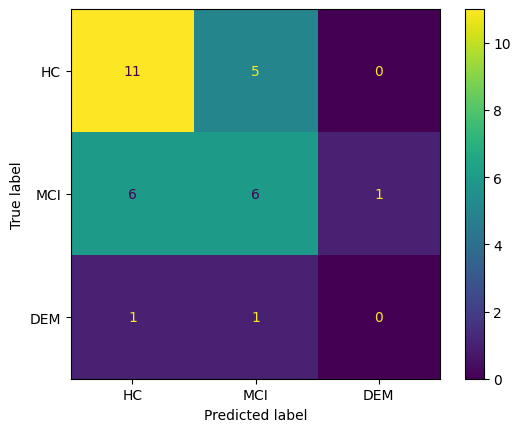

Training knn...
accuracy: 0.452
f1: 0.267
precision: 0.262
recall: 0.301


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


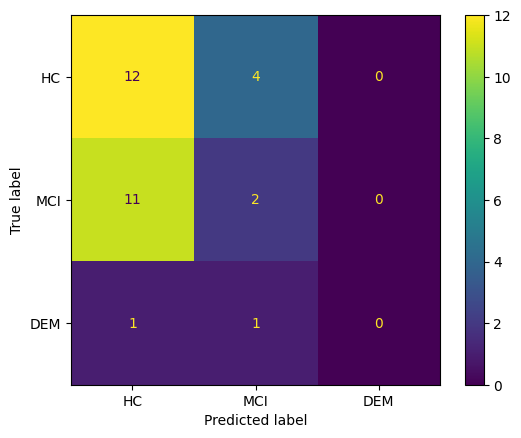

Epoch 10, Loss: 0.5554
Epoch 20, Loss: 0.2950
Epoch 30, Loss: 0.1622
Epoch 40, Loss: 0.0923
Epoch 50, Loss: 0.0593
accuracy: 0.452
f1: 0.285
precision: 0.315
recall: 0.301


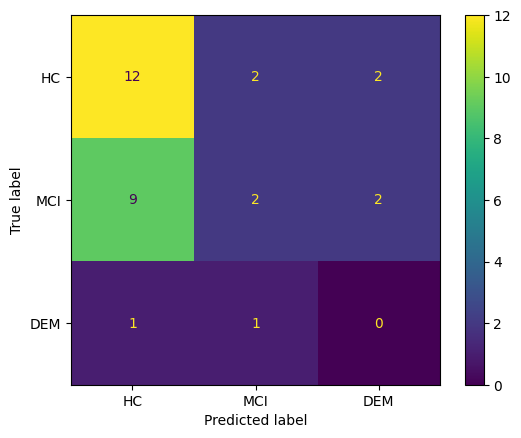

Training lr...
accuracy: 0.484
f1: 0.318
precision: 0.417
recall: 0.327


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


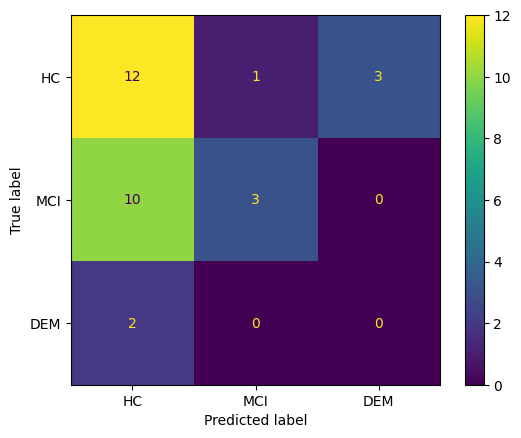

Training svm...
accuracy: 0.516
f1: 0.227
precision: 0.172
recall: 0.333


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


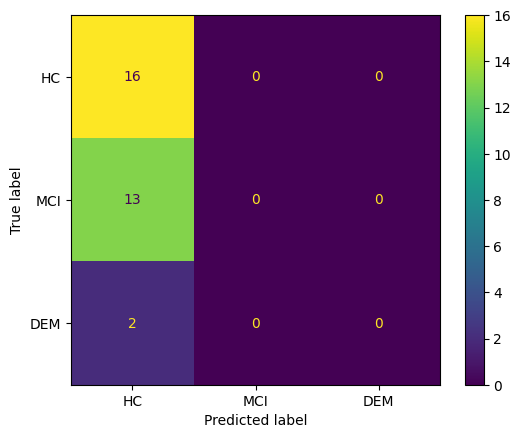

Training rf...
accuracy: 0.452
f1: 0.207
precision: 0.161
recall: 0.292


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


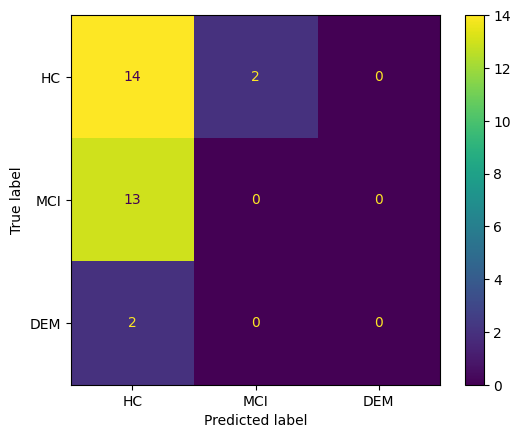

Training knn...
accuracy: 0.419
f1: 0.266
precision: 0.263
recall: 0.285


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


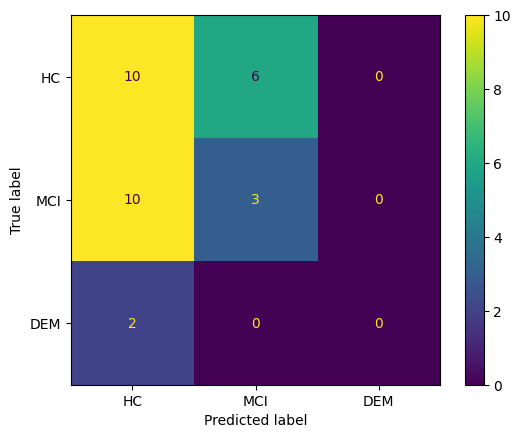

Epoch 10, Loss: 0.6420
Epoch 20, Loss: 0.3485
Epoch 30, Loss: 0.1906
Epoch 40, Loss: 0.0944
Epoch 50, Loss: 0.0483
accuracy: 0.290
f1: 0.154
precision: 0.130
recall: 0.188


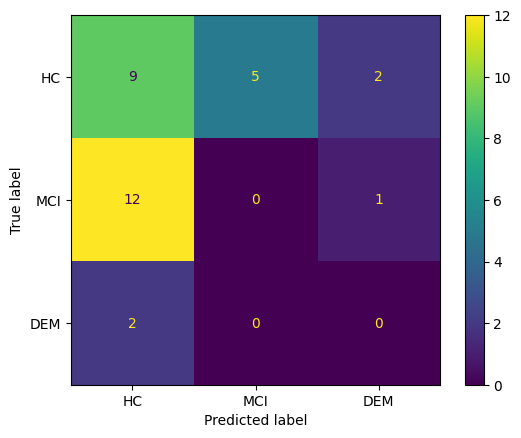

Training lr...
accuracy: 0.516
f1: 0.448
precision: 0.498
recall: 0.439


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


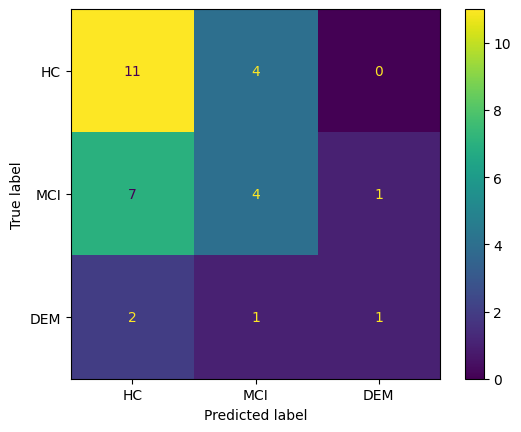

Training svm...
accuracy: 0.484
f1: 0.217
precision: 0.161
recall: 0.333


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


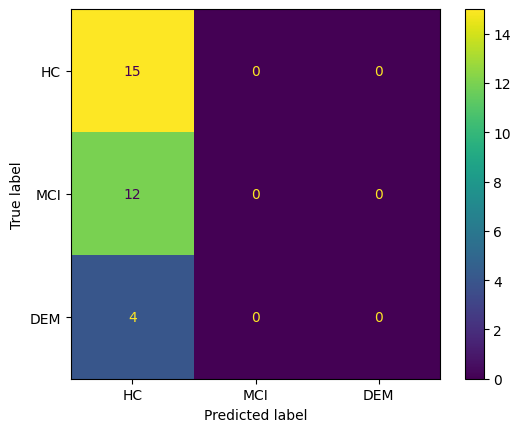

Training rf...
accuracy: 0.484
f1: 0.332
precision: 0.333
recall: 0.356


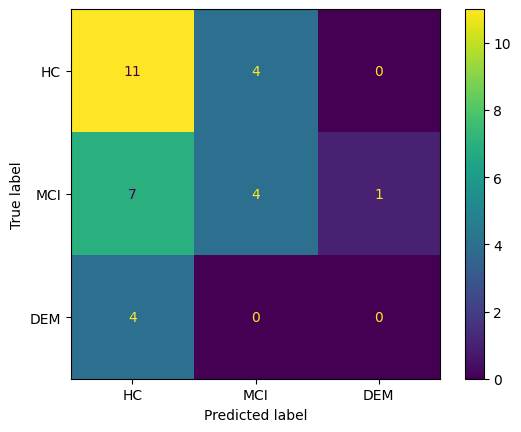

Training knn...
accuracy: 0.484
f1: 0.290
precision: 0.300
recall: 0.344


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


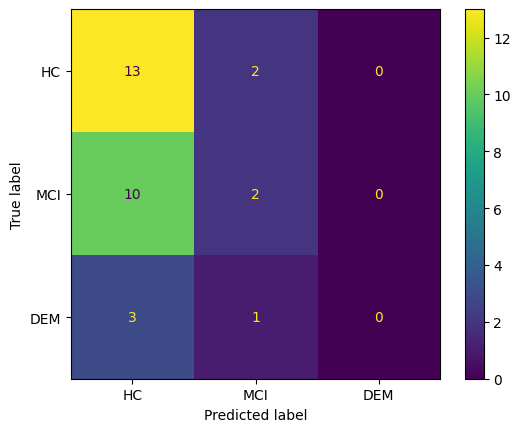

Epoch 10, Loss: 0.5810
Epoch 20, Loss: 0.3039
Epoch 30, Loss: 0.1321
Epoch 40, Loss: 0.0508
Epoch 50, Loss: 0.0219
accuracy: 0.387
f1: 0.277
precision: 0.293
recall: 0.283


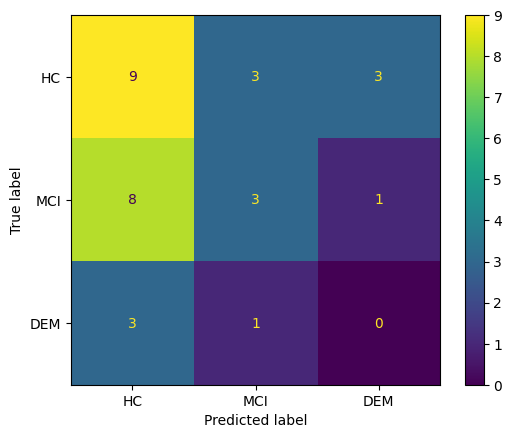

In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# train and validate meta models

lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='minkowski')

for fold in kf_dict.keys():
    print(f"Fold {fold}:")
    fold_dict = kf_dict[fold]
    logits_for_ensemble_training, ensemble_train_label, logits_for_ensemble_validation = fold_dict['logits_for_ensemble_training'], fold_dict['ensemble_train_label'], fold_dict['logits_for_ensemble_validation']
    ensemble_train_features = torch.cat(logits_for_ensemble_training, dim=1).detach()
    ensemble_train_labels = torch.tensor(ensemble_train_label.values, dtype=torch.int64).to(device)
    ensemble_validation_features = torch.cat(logits_for_ensemble_validation, dim=1).detach().to(device)
    # apply machine learning models as metamodel:
    for model_name, ensemble_model in {'lr': lr_model, 'svm': svm_model, 'rf': rf_model, 'knn': knn_model}.items():
        print(f'Training {model_name}...')
        ensemble_model.fit(ensemble_train_features, ensemble_train_labels)
        y_pred = ensemble_model.predict(ensemble_validation_features)
        ensemble_validation_labels = fold_dict['ensemble_dev_label'].to_numpy()
        kf_dict[fold][f'metamodel_{model_name}_results'], kf_dict[fold][f'metamodel_{model_name}_cm_disp'] = calc_metrics(ensemble_validation_labels, y_pred)
    # apply nn model as metamodel:
    nn_meta_model = train_nn_metamodel(features=ensemble_train_features, labels=ensemble_train_labels)
    nn_meta_model.eval()
    with torch.no_grad():
        ensemble_validation_labels = torch.tensor(fold_dict['ensemble_dev_label'].values, dtype=torch.int64).to(device)
        validation_pred = nn_meta_model(ensemble_validation_features).argmax(dim=1)
        kf_dict[fold][f'metamodel_nn_results'], kf_dict[fold][f'metamodel_nn_cm_disp'] = calc_metrics(ensemble_validation_labels, validation_pred)


In [150]:
# view results
TASKS = ['CTD', 'SFT', 'PFT']
for fold in kf_dict.keys():
    print(f"Fold {fold}:")
    fold_dict = kf_dict[fold]
    print('F1 scores')
    for metmodel_name in ['lr', 'svm', 'rf', 'knn', 'nn']:
        f1 = fold_dict[f'metamodel_{metmodel_name}_results']['f1']
        print(f'metamodel_{metmodel_name} {f1:.2f}')
    for task in TASKS:
        f1 = fold_dict[f'{task}_gnn_results']['f1']
        print(f'{task}_gnn {f1:.2f}')


Fold 0:
F1 scores
metamodel_lr 0.47
metamodel_svm 0.45
metamodel_rf 0.42
metamodel_knn 0.31
metamodel_nn 0.44
CTD_gnn 0.29
SFT_gnn 0.34
PFT_gnn 0.46
Fold 1:
F1 scores
metamodel_lr 0.23
metamodel_svm 0.29
metamodel_rf 0.29
metamodel_knn 0.34
metamodel_nn 0.42
CTD_gnn 0.42
SFT_gnn 0.38
PFT_gnn 0.37
Fold 2:
F1 scores
metamodel_lr 0.29
metamodel_svm 0.27
metamodel_rf 0.38
metamodel_knn 0.27
metamodel_nn 0.28
CTD_gnn 0.36
SFT_gnn 0.46
PFT_gnn 0.29
Fold 3:
F1 scores
metamodel_lr 0.32
metamodel_svm 0.23
metamodel_rf 0.21
metamodel_knn 0.27
metamodel_nn 0.15
CTD_gnn 0.37
SFT_gnn 0.40
PFT_gnn 0.34
Fold 4:
F1 scores
metamodel_lr 0.45
metamodel_svm 0.22
metamodel_rf 0.33
metamodel_knn 0.29
metamodel_nn 0.28
CTD_gnn 0.33
SFT_gnn 0.34
PFT_gnn 0.34
